In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [5]:
# download dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


In [13]:
# create lightweight CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x, visualize=False):

        x = self.conv1(x)
        x = self.relu(x)

        if visualize:
            return x   # return feature maps of first conv layer

        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = CNN().cuda()

In [14]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# training loop
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

print("Training Finished")

Epoch 1, Loss: 1.3906160714986073
Epoch 2, Loss: 1.0644540830951212
Epoch 3, Loss: 0.941250329508501
Epoch 4, Loss: 0.8654152572612324
Epoch 5, Loss: 0.8018725863503068
Epoch 6, Loss: 0.755818694258285
Epoch 7, Loss: 0.7133071884474791
Epoch 8, Loss: 0.6797550489835422
Epoch 9, Loss: 0.6501045046407549
Epoch 10, Loss: 0.6216700544290226
Training Finished


In [38]:
# calculate accuracy
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Test Accuracy:", correct / total)

Test Accuracy: 0.739


In [17]:
# flatten images
from sklearn.svm import SVC

X_train = trainset.data.reshape(len(trainset), -1)
y_train = trainset.targets

X_test = testset.data.reshape(len(testset), -1)
y_test = testset.targets

In [ ]:
# train svm
svm = SVC()
svm.fit(X_train[:10000], y_train[:10000])
print("SVM Accuracy:", svm.score(X_test[:2000], y_test[:2000]))

SVM Accuracy: 0.4665


In [40]:
# logistic regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train_subset = X_train[:10000]
y_train_subset = y_train[:10000]

X_test_subset = X_test[:2000]
y_test_subset = y_test[:2000]

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test_subset)

# train Logistic Regression
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_scaled, y_train_subset)

# Evaluate
print("Logistic Regression Accuracy:",
      lr.score(X_test_scaled, y_test_subset))

Logistic Regression Accuracy: 0.2815


Feature map shape: torch.Size([1, 32, 32, 32])


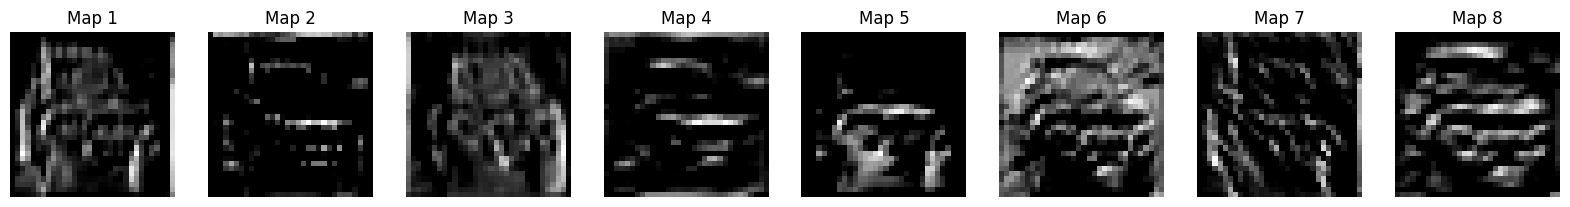

In [34]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model, dataset, device):

    model.eval()

    # Get one sample image
    image, label = dataset[9]
    image = image.unsqueeze(0).to(device)

    # Get feature maps
    with torch.no_grad():
        feature_maps = model(image, visualize=True)

    feature_maps = feature_maps.cpu()

    print("Feature map shape:", feature_maps.shape)

    # Plot first 8 feature maps
    fig, axes = plt.subplots(1, 8, figsize=(20,5))

    for i in range(8):
        axes[i].imshow(feature_maps[0, i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Map {i+1}')

    plt.show()

visualize_feature_maps(model, testset, device)

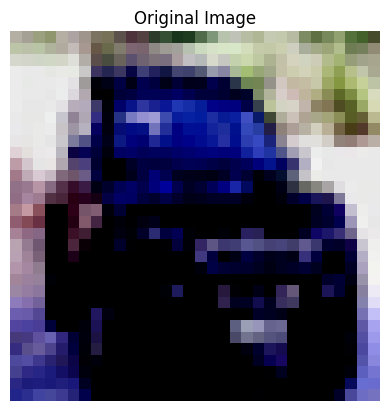

In [35]:
# Get one sample image testset for display
image, _ = testset[9]

# Permute and display the image
plt.imshow(image.permute(1,2,0).cpu())
plt.title("Original Image")
plt.axis("off")
plt.show()

In [36]:
# save model
torch.save(model.state_dict(), "cnn_cifar10.pth")